In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import corner

import nestle
import dynesty as dn
import emcee
from dynesty import plotting as dyplot

## EGG BOX - multimodal

To test the performance of samplers, we'll use the eggbox model demonstrated in the nestle examples, using bilby to choose different samplers.

In [2]:
tmax = 5.0 * np.pi
constant = np.log(1.0 / tmax**2)

def loglike(x):
    t = 2.0 * tmax * x - tmax
#     u = 2.0 * tmax * y - tmax
    return (2.0 + np.cos(t[0]/2.0)*np.cos(t[1]/2.0))**5.0

def prior(x):
    return x

Text(0.5, 1.0, 'True Log likelihood surface')

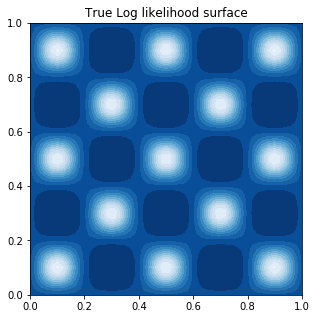

In [3]:
plt.figure(figsize=(5., 5.))
ax = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(0., 1., 50),
                     np.linspace(0., 1., 50))
Z = loglike(np.array([xx, yy]))
ax.contourf(xx, yy, Z, 12, cmap=plt.cm.Blues_r)
plt.title("True Log likelihood surface")

## nestle

niter: 1541
ncall: 2946
nsamples: 1741
logz: 236.167 +/-  0.172
h:  5.883


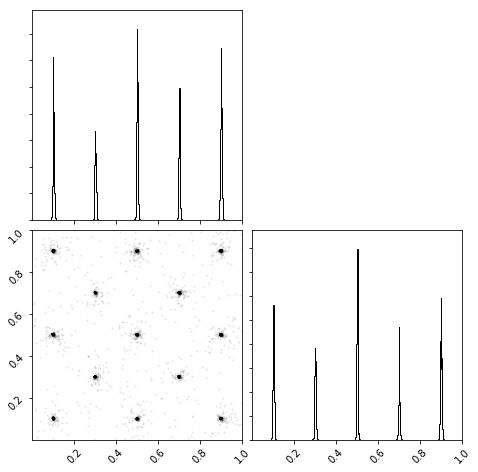

In [4]:
res = nestle.sample(loglike, prior, 2, npoints=200, method='multi',
                    update_interval=20)
print(res.summary())
fig = corner.corner(res.samples, weights=res.weights, bins=500,
                    range=[(0., 1.), (0., 1.)])
fig.set_size_inches(8., 8.)

## dynesty

In [5]:
import dynesty as dn

In [6]:
# sampling on the unit cube so our samples are already normalized on (0,1)
def ptform(u):
    return u

In [7]:
# "Static" nested sampling.
ndim = 2

sampler = dn.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(loglike, ptform, ndim)
dsampler.run_nested()
dresults = dsampler.results

iter: 21493 | batch: 11 | bound: 58 | nc: 1 | ncall: 55881 | eff(%): 38.462 | loglstar: 235.266 < 242.999 < 242.662 | logz: 235.984 +/-  0.156 | stop:  0.964                                         


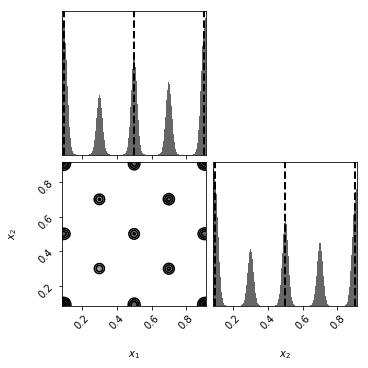

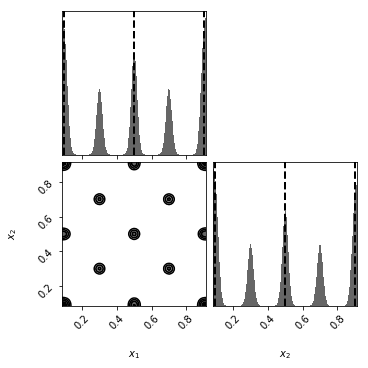

In [8]:
cfig, caxes = dyplot.cornerplot(sresults)
cdfig, cdaxes = dyplot.cornerplot(dresults)

### emcee

In [9]:
import emcee

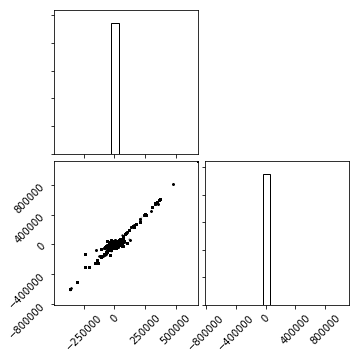

In [10]:
ndim, nwalkers = 2, 1000
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler.run_mcmc(p0, 10000)

samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples)

## Applying samplers to the function from the minimizers example

In [11]:
def f2min(x):
    return -(x[0]**2-1)*(x[1]**2-1)*np.cos(4*np.pi*x[0])*np.cos(2*np.pi*x[1])

def ptform_f2(u):
    return 2. * u - 1

niter: 3314
ncall: 8711
nsamples: 5314
logz:  0.030 +/-  0.004
h:  0.035


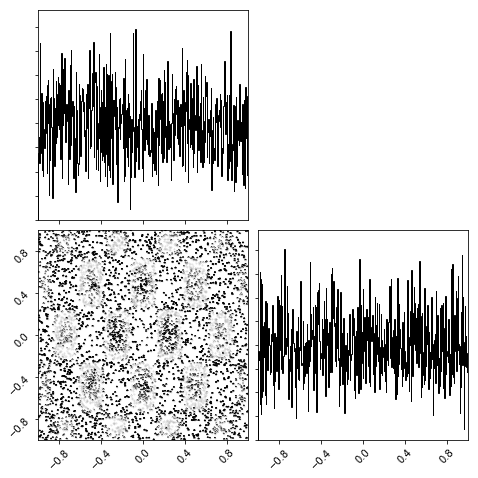

In [12]:
res = nestle.sample(f2min, ptform_f2, 2, npoints=2000, method='multi',
                    update_interval=20)
print(res.summary())
fig = corner.corner(res.samples, weights=res.weights, bins=500,
                    range=[(-1., 1.), (-1., 1.)])
fig.set_size_inches(8., 8.)

In [13]:
# "Static" nested sampling.
ndim = 2

sampler = dn.NestedSampler(f2min, ptform_f2, ndim)
sampler.run_nested()
sresults = sampler.results

# "Dynamic" nested sampling.
dsampler = dn.DynamicNestedSampler(f2min, ptform_f2, ndim)
dsampler.run_nested()
dresults = dsampler.results

iter: 16581 | batch: 16 | bound: 0 | nc: 1 | ncall: 40141 | eff(%): 41.307 | loglstar:   -inf <  0.933 <  0.361 | logz:  0.038 +/-  0.041 | stop:  0.915                                              


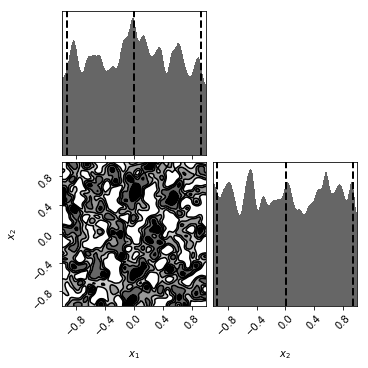

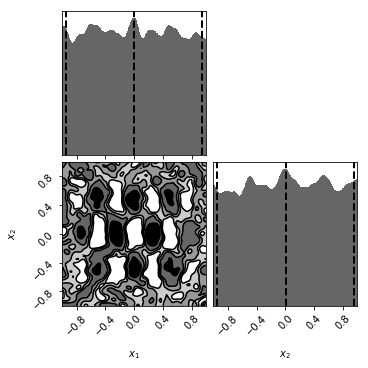

In [14]:
cfig, caxes = dyplot.cornerplot(sresults)
cdfig, cdaxes = dyplot.cornerplot(dresults)

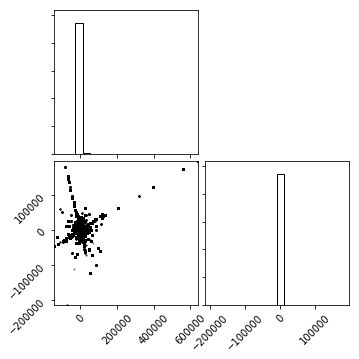

In [15]:
ndim, nwalkers = 2, 1000
p0 = [np.random.rand(ndim) for i in range(nwalkers)]

sampler_e = emcee.EnsembleSampler(nwalkers, ndim, loglike)
sampler_e.run_mcmc(p0, 10000)

samples = sampler_e.chain[:, 500:, :].reshape((-1, ndim))
fig = corner.corner(samples)

## Conclusion

(Current) conclusion: nested sampling will ALWAYS do well, but will take long (especially with more expensive and complex models). emcee isn't good for multimodal distributions (see fitting a model for more emcee applications). 

Also, pymc3 and bilby will take longer for us to become comfortable enough with to include here. People with more experience are welcome to contribute to this notebook!